In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
dtype = torch.FloatTensor

In [3]:
sentences = [ "i like dog", "i like cat", "i like animal", 
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie", "book music like", "cat dog hate", "cat dog like"]

# Tokenize text

In [4]:
word_sequence = " ".join(sentences).split()

In [5]:
word_tokens = list(set(word_sequence))

# Build word dict

In [6]:
word_dict = { word:i for i, word in enumerate(word_tokens)}

In [7]:
batch_size = 20  # To show 2 dim embedding graph
embedding_size = 2  # To show 2 dim embedding graph
voc_size = len(word_tokens)

In [8]:
# input word
j = 1
print("Input word : ")
print(word_sequence[j], word_dict[word_sequence[j]])

# context words
print("Context words : ")
print(word_sequence[j - 1], word_sequence[j + 1])
print([word_dict[word_sequence[j - 1]], word_dict[word_sequence[j + 1]]])

Input word : 
like 11
Context words : 
i dog
[12, 10]


In [9]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([input, w])


#lets plot some data
skip_grams[:6]

[[11, 12], [11, 10], [10, 11], [10, 12], [12, 10], [12, 11]]

In [10]:
np.random.seed(172)
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # input
        random_labels.append(data[i][1])  # context word
    return random_inputs, random_labels
random_batch(skip_grams[:6], size=3)  

([array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])],
 [12, 10, 12])

In [11]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size -> embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size -> voc_size Weight
    def forward(self, X):
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        #return output_layer 
        return output_layer

In [12]:
model = Word2Vec()
# Set the model in train mode
model.train()

criterion = nn.CrossEntropyLoss() # Softmax (for multi-class classification problems) is already included
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # new_tensor(data, dtype=None, device=None, requires_grad=False)
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  import sys


Epoch: 1000 cost = 2.238925
Epoch: 2000 cost = 1.908845
Epoch: 3000 cost = 1.841595
Epoch: 4000 cost = 1.946872
Epoch: 5000 cost = 1.955889


In [14]:
# Learned W
W, _= model.parameters()
print(W.detach())

tensor([[-0.7868, -3.1684],
        [-2.6984,  0.5906],
        [ 0.2001, -1.3972],
        [ 1.8704,  1.9498],
        [-0.2106, -2.7836],
        [ 0.1352, -1.1965],
        [ 1.1232, -0.1939],
        [ 0.4504,  0.7401],
        [-1.6695, -0.0618],
        [ 0.8087, -1.8583],
        [-0.6793, -1.4004],
        [ 1.3361, -1.0274],
        [-0.6535, -0.9179]])


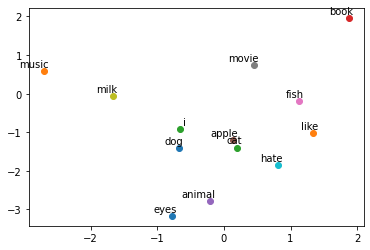

In [15]:
for i, word in enumerate(word_tokens):
    W, _= model.parameters()
    W = W.detach()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()